In [13]:
import tensorflow as tf
import keras
import matplotlib
from keras.datasets import mnist

In [14]:
(train_data, train_labels), (_, _) = mnist.load_data()

In [15]:
train_data = train_data.reshape(train_data.shape[0], 28, 28, 1).astype("float32")
train_data = (train_data - 127.5) / 127.5

In [16]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [18]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_data).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [21]:
dir(train_dataset)

['_GeneratorState',
 '__abstractmethods__',
 '__bool__',
 '__class__',
 '__class_getitem__',
 '__debug_string__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__nonzero__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__tf_tracing_type__',
 '__weakref__',
 '_abc_impl',
 '_add_trackable_child',
 '_add_variable_with_custom_getter',
 '_apply_debug_options',
 '_as_serialized_graph',
 '_batch_size',
 '_checkpoint_dependencies',
 '_common_args',
 '_consumers',
 '_convert_variables_to_tensors',
 '_deferred_dependencies',
 '_deserialization_dependencies',
 '_deserialize_from_proto',
 '_drop_remainder',
 '_export_to_saved_model_graph',
 '_flat_shapes',
 '_flat_structure',
 '_flat_types',
 '

## THE GENERATOR MODEL

In [22]:
from keras import layers

In [28]:
def generator():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7 * 7 * 256, use_bias = False, input_shape = (100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)

    model.add(layers.Conv2DTranspose(128, (5, 5), strides = (1, 1), padding = "same", use_bias = False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides = (2, 2), padding = "same", use_bias = False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides = (2, 2), padding = "same", use_bias = False))
    assert model.output_shape == (None, 28, 28, 1)

    return model



In [29]:
untrained_gen_img = generator()

In [30]:
noise = tf.random.normal([1, 100])
gen_img = untrained_gen_img(noise, training = False)

In [31]:
import matplotlib.pyplot as plt

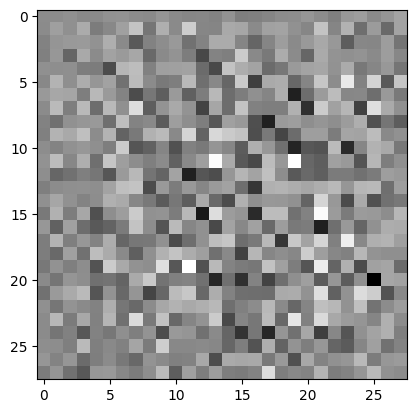

In [32]:
plt.imshow(gen_img[0, :, :, 0], cmap ="gray")

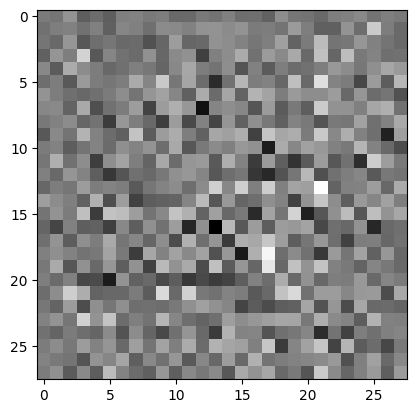

In [33]:
noise = tf.random.normal([1, 100])
gen_img = untrained_gen_img(noise, training = False)
plt.imshow(gen_img[0, :, :, 0], cmap ="gray")

## THE DISCRIMATOR

In [37]:
def discriminator():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides = (2, 2), padding = "same", input_shape = [28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(128, (5, 5), strides = (2, 2), padding = "same"))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [40]:
disc_model = discriminator()
decision = disc_model(gen_img)
print(decision)

tf.Tensor([[-0.00225415]], shape=(1, 1), dtype=float32)
